In [1]:
import os
import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re

import setGPU

I0510 15:00:51.426460 140232862971712 file_utils.py:38] PyTorch version 1.4.0 available.
I0510 15:00:51.427439 140232862971712 file_utils.py:54] TensorFlow version 2.1.0 available.


setGPU: Setting GPU to: 1


In [2]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [4]:
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path=None, num_class=None):
        super(TFGPT2Classifier, self).__init__()
        
        self.dir_path = 'gpt2' if dir_path is None else dir_path
        
        self.gpt2 = TFGPT2Model.from_pretrained(self.dir_path)
        self.num_class = self.gpt2.config.num_labels if num_class is None else num_class
        
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        pooled_output = outputs[0][:, -1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:] 

        return outputs

In [5]:
TOKENIZER_PATH = './gpt_ckpt/kogpt2_news_wiki_ko_cased_818bfa919d.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token='$',
                                               cls_token='@',
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

In [6]:
#random seed 고정

tf.random.set_seed(0)
np.random.seed(0)

BATCH_SIZE = 192
NUM_EPOCHS = 20
VALID_SPLIT = 0.1
MAX_LEN = 64
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [17]:
# 데이터 전처리 준비

DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_train.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_test.txt")

train_data = pd.read_csv(DATA_TRAIN_PATH, header = 0, delimiter = '\t', quoting = 3)
train_data = train_data.dropna()
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [18]:
# 텍스트 전처리

def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sent)
    return sent_clean

In [19]:
# train_data = train_data[:1000] # for test

train_data_sents = list()
train_data_labels = list()

for train_sent, train_label in zip(train_data['document'], train_data['label']):
    tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(clean_text(train_sent))] + [vocab[vocab.eos_token],]
    train_data_sents.append(tokens)
    train_data_labels.append(train_label)

train_data_sents = pad_sequences(train_data_sents, MAX_LEN - 1, value=vocab[vocab.padding_token])#, padding='post')
cls_tokens = [[vocab[vocab.cls_token]]] * train_data_sents.shape[0]

train_data_sents = np.concatenate((train_data_sents, cls_tokens), axis=-1)

train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

In [20]:
cls_model = TFGPT2Classifier('./gpt_ckpt')

I0506 15:35:05.369257 140047217469248 configuration_utils.py:252] loading configuration file ./gpt_ckpt/config.json
I0506 15:35:05.370854 140047217469248 configuration_utils.py:290] Model config GPT2Config {
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "embd_pdrop": 0.1,
  "eos_token_ids": null,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_beams": 1,
  "num_labels": 2,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": null,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "resid_pdrop": 0.

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [22]:
model_name = "tf2_gpt2_naver_movie"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = cls_model.fit(train_data_sents, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

data_out/KORtf2_gpt2_naver_movie -- Folder already exists 

Train on 134995 samples, validate on 15000 samples
Epoch 1/20
134976/134995 [============================>.] - ETA: 0s - loss: 0.3273 - accuracy: 0.8555
Epoch 00001: val_accuracy improved from -inf to 0.87973, saving model to data_out/KORtf2_gpt2_naver_movie/weights.h5
134995/134995 [==============================] - 606s 4ms/sample - loss: 0.3273 - accuracy: 0.8555 - val_loss: 0.2787 - val_accuracy: 0.8797
Epoch 2/20
134976/134995 [============================>.] - ETA: 0s - loss: 0.2495 - accuracy: 0.8952
Epoch 00002: val_accuracy improved from 0.87973 to 0.89147, saving model to data_out/KORtf2_gpt2_naver_movie/weights.h5
134995/134995 [==============================] - 590s 4ms/sample - loss: 0.2495 - accuracy: 0.8952 - val_loss: 0.2621 - val_accuracy: 0.8915
Epoch 3/20
134976/134995 [============================>.] - ETA: 0s - loss: 0.2041 - accuracy: 0.9163
Epoch 00003: val_accuracy improved from 0.89147 to 0.89573, savi

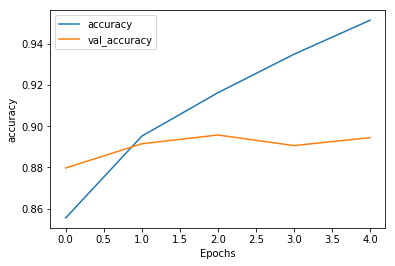

In [23]:
plot_graphs(history, 'accuracy')

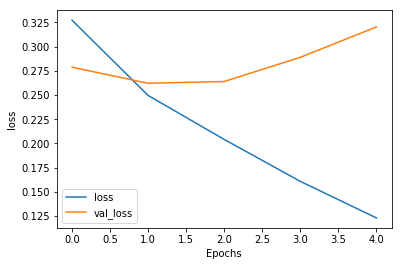

In [24]:
plot_graphs(history, 'loss')

# Bag of Words Test Dataset (제출 확인 필요)

In [25]:
test_data = pd.read_csv(DATA_TEST_PATH, header = 0, delimiter = '\t', quoting = 3)
test_data = test_data.dropna()
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [26]:
# test_data = test_data[:50] # for test

test_data_sents = list()
test_data_labels = list()

for test_sent, test_label in zip(test_data['document'], test_data['label']):
    tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(clean_text(test_sent))] + [vocab[vocab.eos_token],]
    test_data_sents.append(tokens)
    test_data_labels.append(test_label)

test_data_sents = pad_sequences(test_data_sents, MAX_LEN - 1, value=vocab[vocab.padding_token])#, padding='post')
cls_tokens = [[vocab[vocab.cls_token]]] * test_data_sents.shape[0]

test_data_sents = np.concatenate((test_data_sents, cls_tokens), axis=-1)

test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [27]:
print("num sents, labels {}, {}".format(len(test_data_sents), len(test_data_labels)))

num sents, labels 49997, 49997


In [ ]:
results = cls_model.evaluate(test_data_sents, test_data_labels)
print("test loss, test acc: ", results)

# Quora Simliarity (ENG)

In [7]:
BATCH_SIZE = 128
NUM_EPOCHS = 20
VALID_SPLIT = 0.2
# MAX_LEN = 14 * 2 # Average total * 2
MAX_LEN = 80 # Average total * 2

In [23]:
# Load Train dataset

TRAIN_SNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'snli_1.0_train.kor')
TRAIN_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'multinli.train.ko.tsv')
DEV_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.dev.ko.tsv')

train_data_snli = pd.read_csv(TRAIN_SNLI_DF, header=0, delimiter = '\t', quoting = 3)
train_data_xnli = pd.read_csv(TRAIN_XNLI_DF, header=0, delimiter = '\t', quoting = 3)
dev_data_xnli = pd.read_csv(DEV_XNLI_DF, header=0, delimiter = '\t', quoting = 3)

train_data_snli_xnli = train_data_snli.append(train_data_xnli)
train_data_snli_xnli = train_data_snli_xnli.dropna()
train_data_snli_xnli = train_data_snli_xnli.reset_index()

dev_data_xnli = dev_data_xnli.dropna()

print("Total # dataset: train - {}, dev - {}".format(len(train_data_snli_xnli), len(dev_data_xnli)))

Total # dataset: train - 942808, dev - 2490


In [25]:
# train_data_xnli = train_data_xnli[:50] # for test

# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근
def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
    return sent_clean

train_data_sent_1 = list()
train_data_sent_2 = list()

for train_sent_1, train_sent_2 in zip(train_data_snli_xnli['sentence1'], train_data_snli_xnli['sentence2']):
#     tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(clean_text(train_sent_1))] + [vocab[vocab.eos_token],] + \
#     [vocab[vocab.sep_token],] + [vocab[vocab.bos_token],]  + vocab[tokenizer(clean_text(train_sent_2))] + [vocab[vocab.eos_token]]
    train_data_sent_1.append(vocab[tokenizer(clean_text(train_sent_1))])
    train_data_sent_2.append(vocab[tokenizer(clean_text(train_sent_2))])

train_data_sent_1 = pad_sequences(train_data_sent_1, MAX_LEN // 2, value=vocab[vocab.padding_token])#, padding='post')
train_data_sent_2 = pad_sequences(train_data_sent_2, MAX_LEN // 2, value=vocab[vocab.padding_token])#, padding='post')

bos_tokens = np.asarray([[vocab[vocab.bos_token]]] * train_data_sent_1.shape[0], dtype=np.int64)
eos_tokens = np.asarray([[vocab[vocab.eos_token]]] * train_data_sent_1.shape[0], dtype=np.int64)
sep_tokens = np.asarray([[vocab[vocab.sep_token]]] * train_data_sent_1.shape[0], dtype=np.int64)
cls_tokens = np.asarray([[vocab[vocab.cls_token]]] * train_data_sent_1.shape[0], dtype=np.int64)

train_data_sents = np.concatenate((bos_tokens, train_data_sent_1, eos_tokens, sep_tokens, 
                                   bos_tokens, train_data_sent_2, eos_tokens, cls_tokens), axis=-1)

train_data_sents = np.array(train_data_sents, dtype=np.int64)

In [27]:
train_data_sents[0]

array([    0,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,  3214,   996,  2373, 13952, 47612,
       16540,  5886,  3564, 47531,  4394,     1, 48140,     0,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,   118,  2373,  9442,   264,  3214,
        2777,  4106,   123,     1, 47810])

In [28]:
# train_data_xnli = train_data_xnli[:50] # for test

dev_data_sent_1 = list()
dev_data_sent_2 = list()

for dev_sent_1, dev_sent_2 in zip(dev_data_xnli['sentence1'], dev_data_xnli['sentence2']):
    dev_data_sent_1.append(vocab[tokenizer(clean_text(dev_sent_1))])
    dev_data_sent_2.append(vocab[tokenizer(clean_text(dev_sent_2))])

dev_data_sent_1 = pad_sequences(dev_data_sent_1, MAX_LEN // 2, value=vocab[vocab.padding_token])#, padding='post')
dev_data_sent_2 = pad_sequences(dev_data_sent_2, MAX_LEN // 2, value=vocab[vocab.padding_token])#, padding='post')

bos_tokens = np.asarray([[vocab[vocab.bos_token]]] * dev_data_sent_1.shape[0], dtype=np.int64)
eos_tokens = np.asarray([[vocab[vocab.eos_token]]] * dev_data_sent_1.shape[0], dtype=np.int64)
sep_tokens = np.asarray([[vocab[vocab.sep_token]]] * dev_data_sent_1.shape[0], dtype=np.int64)
cls_tokens = np.asarray([[vocab[vocab.cls_token]]] * dev_data_sent_1.shape[0], dtype=np.int64)

dev_data_sents = np.concatenate((bos_tokens, dev_data_sent_1, eos_tokens, sep_tokens, 
                                   bos_tokens, dev_data_sent_2, eos_tokens, cls_tokens), axis=-1)

dev_data_sents = np.array(dev_data_sents, dtype=np.int64)

In [29]:
# Label을 Netural, Contradiction, Entailment 에서 숫자 형으로 변경한다.
label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2}
def convert_int(label):
    num_label = label_dict[label]    
    return num_label

train_data_snli_xnli["gold_label_int"] = train_data_snli_xnli["gold_label"].apply(convert_int)
train_data_labels = np.array(train_data_snli_xnli['gold_label_int'], dtype=int)

dev_data_xnli["gold_label_int"] = dev_data_xnli["gold_label"].apply(convert_int)
dev_data_labels = np.array(dev_data_xnli['gold_label_int'], dtype=int)

print("# train labels: {}, #dev labels: {}".format(len(train_data_labels), len(dev_data_labels)))

# train labels: 942808, #dev labels: 2490


In [30]:
sim_model = TFGPT2Classifier('./gpt_ckpt', 3)

I0510 15:13:03.469924 140232862971712 configuration_utils.py:252] loading configuration file ./gpt_ckpt/config.json
I0510 15:13:03.471653 140232862971712 configuration_utils.py:290] Model config GPT2Config {
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "embd_pdrop": 0.1,
  "eos_token_ids": null,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_beams": 1,
  "num_labels": 2,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": null,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "resid_pdrop": 0.

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
sim_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model_name = "tf2_gpt_kornli"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = sim_model.fit(train_data_sents, train_data_labels, epochs=NUM_EPOCHS,
                        validation_data = (dev_data_sents, dev_data_labels),
            batch_size=BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])

data_out/KOR/tf2_gpt_kornli -- Folder already exists 

Train on 942808 samples, validate on 2490 samples
Epoch 1/20
942720/942808 [============================>.] - ETA: 0s - loss: 0.5973 - accuracy: 0.7533
Epoch 00001: val_accuracy improved from -inf to 0.75823, saving model to data_out/KOR/tf2_gpt_kornli/weights.h5
942808/942808 [==============================] - 5518s 6ms/sample - loss: 0.5973 - accuracy: 0.7533 - val_loss: 0.6035 - val_accuracy: 0.7582
Epoch 2/20
942720/942808 [============================>.] - ETA: 0s - loss: 0.4785 - accuracy: 0.8113
Epoch 00002: val_accuracy improved from 0.75823 to 0.76426, saving model to data_out/KOR/tf2_gpt_kornli/weights.h5
942808/942808 [==============================] - 5519s 6ms/sample - loss: 0.4784 - accuracy: 0.8113 - val_loss: 0.5944 - val_accuracy: 0.7643
Epoch 3/20
942720/942808 [============================>.] - ETA: 0s - loss: 0.4121 - accuracy: 0.8409
Epoch 00003: val_accuracy improved from 0.76426 to 0.76988, saving model to da

In [46]:
model_name = "tf2_gpt_kornli"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = sim_model.fit(train_data_sents, train_data_labels, epochs=NUM_EPOCHS,
                        validation_split = 0.1,
            batch_size=BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])

data_out/KOR/tf2_gpt_kornli -- Folder already exists 

Train on 848527 samples, validate on 94281 samples
Epoch 1/20
848512/848527 [============================>.] - ETA: 0s - loss: 0.1890 - accuracy: 0.9313
Epoch 00001: val_accuracy improved from -inf to 0.96007, saving model to data_out/KOR/tf2_gpt_kornli/weights.h5
848527/848527 [==============================] - 5159s 6ms/sample - loss: 0.1890 - accuracy: 0.9313 - val_loss: 0.1144 - val_accuracy: 0.9601
Epoch 2/20
848512/848527 [============================>.] - ETA: 0s - loss: 0.1648 - accuracy: 0.9401
Epoch 00002: val_accuracy did not improve from 0.96007
848527/848527 [==============================] - 5152s 6ms/sample - loss: 0.1648 - accuracy: 0.9401 - val_loss: 0.1367 - val_accuracy: 0.9503
Epoch 3/20
848512/848527 [============================>.] - ETA: 0s - loss: 0.1439 - accuracy: 0.9479
Epoch 00003: val_accuracy did not improve from 0.96007
848527/848527 [==============================] - 5160s 6ms/sample - loss: 0.1439 -

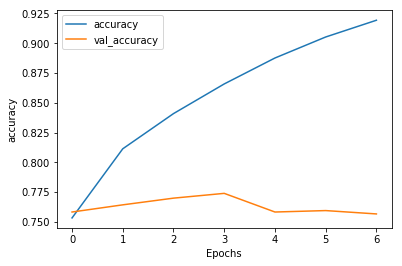

In [37]:
plot_graphs(history, 'accuracy')

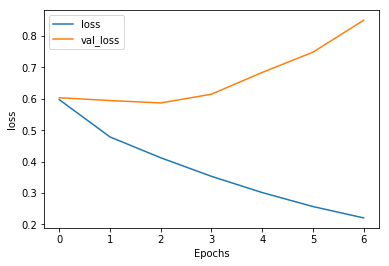

In [39]:
plot_graphs(history, 'loss')

# Quora Simliarity TEST

In [41]:
# Load Test dataset
TEST_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.test.ko.tsv')

test_data_xnli = pd.read_csv(TEST_XNLI_DF, header=0, delimiter = '\t', quoting = 3)

In [43]:
# test_data_xnli = test_data_xnli[:50] # for test

test_data_sent_1 = list()
test_data_sent_2 = list()

for test_sent_1, test_sent_2 in zip(test_data_xnli['sentence1'], test_data_xnli['sentence2']):
    test_data_sent_1.append(vocab[tokenizer(clean_text(test_sent_1))])
    test_data_sent_2.append(vocab[tokenizer(clean_text(test_sent_2))])

test_data_sent_1 = pad_sequences(test_data_sent_1, MAX_LEN // 2, value=vocab[vocab.padding_token])#, padding='post')
test_data_sent_2 = pad_sequences(test_data_sent_2, MAX_LEN // 2, value=vocab[vocab.padding_token])#, padding='post')

bos_tokens = np.asarray([[vocab[vocab.bos_token]]] * test_data_sent_1.shape[0], dtype=np.int64)
eos_tokens = np.asarray([[vocab[vocab.eos_token]]] * test_data_sent_1.shape[0], dtype=np.int64)
sep_tokens = np.asarray([[vocab[vocab.sep_token]]] * test_data_sent_1.shape[0], dtype=np.int64)
cls_tokens = np.asarray([[vocab[vocab.cls_token]]] * test_data_sent_1.shape[0], dtype=np.int64)

test_data_sents = np.concatenate((bos_tokens, test_data_sent_1, eos_tokens, sep_tokens, 
                                   bos_tokens, test_data_sent_2, eos_tokens, cls_tokens), axis=-1)

test_data_sents = np.array(test_data_sents, dtype=np.int64)

In [44]:
test_data_xnli["gold_label_int"] = test_data_xnli["gold_label"].apply(convert_int)
test_data_labels = np.array(test_data_xnli['gold_label_int'], dtype=int)

print("# sents: {}, # labels: {}".format(len(test_data_sents), len(test_data_labels)))

# sents: 5010, # labels: 5010


In [45]:
results = sim_model.evaluate(test_data_sents, test_data_labels)
print("test loss, test acc: ", results)

5010/5010 [==============================] - 11s 2ms/sample - loss: 0.7918 - accuracy: 0.7613
test loss, test acc:  [0.7918447279406641, 0.76127744]


# Valid 0.1 Set으로 진행

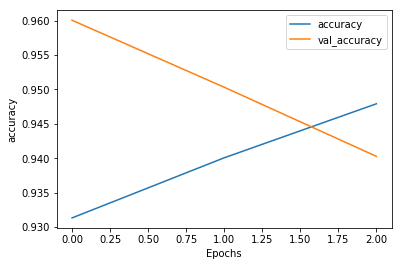

In [48]:
plot_graphs(history, 'accuracy')

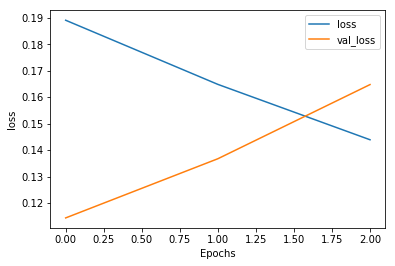

In [49]:
plot_graphs(history, 'loss')

In [47]:
results = sim_model.evaluate(test_data_sents, test_data_labels)
print("test loss, test acc: ", results)

5010/5010 [==============================] - 11s 2ms/sample - loss: 0.9831 - accuracy: 0.7591
test loss, test acc:  [0.9831202033988968, 0.75908184]
